In [1]:
#pip install ydata-profiling

In [2]:
#!pip install imbalanced-learn

In [3]:
#!pip install shap

In [4]:
#importing libraries
import pandas as pd
import shap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from scipy import stats
from scipy.stats import normaltest
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
print(pd.__version__)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from ydata_profiling import ProfileReport
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)
import pandas as pd
from sklearn.metrics import RocCurveDisplay
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

2.2.3


In [5]:
loan_data = pd.read_csv("loan_data.csv")

In [6]:
profile = ProfileReport(loan_data, title="Data Profile", explorative=True)
profile.to_notebook_iframe() 

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 29.27it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
#The percentage of loan vs. no loan
loan_counts = loan_data['loan_status'].value_counts(normalize = True) * 100
# Display the percentages
print(f"Percentage of loan not approved: {loan_counts[0]:.0f}%")
print(f"Percentage of loan approved: {loan_counts[1]:.0f}%")

Percentage of loan not approved: 78%
Percentage of loan approved: 22%


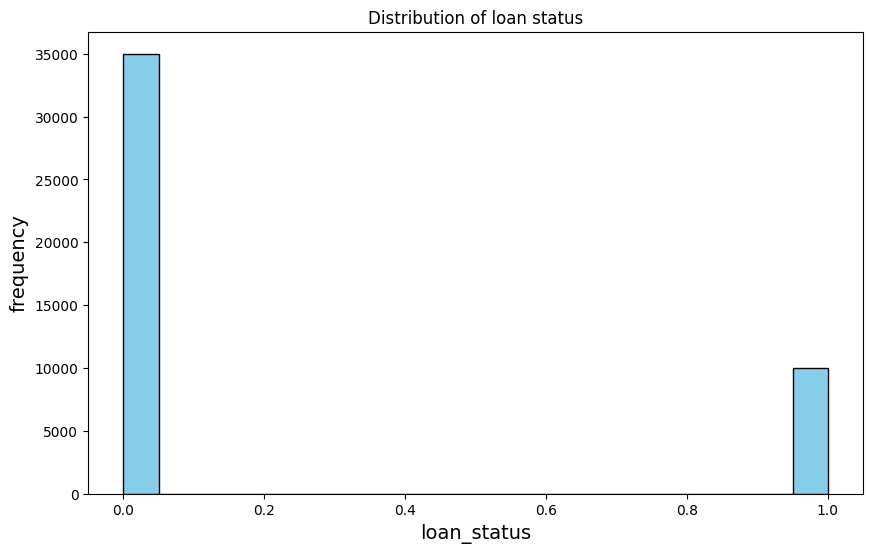

In [8]:
# Visualizing the distribution of our target
plt.figure(figsize = (10,6))
plt.hist(loan_data['loan_status'],bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of loan status')
plt.xlabel('loan_status', fontsize = 14)
plt.ylabel('frequency', fontsize = 14)

plt.show()

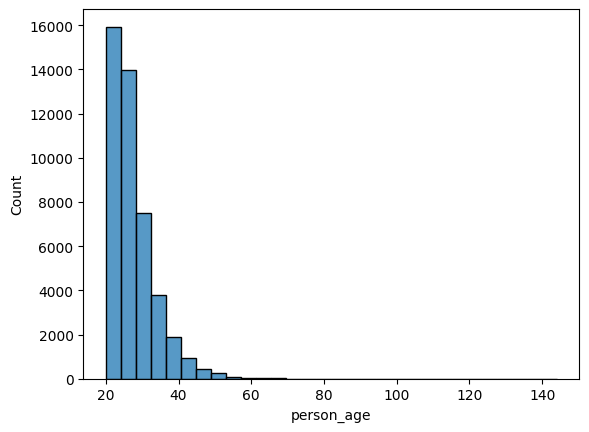

In [9]:
sns.histplot(loan_data['person_age'], bins = 30)
plt.show()

In [10]:
#filtering the outliers in age 
clean_load_data = loan_data[loan_data['person_age'] <= 90]
clean_load_data

person_age person_gender person_education  person_income  \
0            22.0        female           Master        71948.0   
1            21.0        female      High School        12282.0   
2            25.0        female      High School        12438.0   
3            23.0        female         Bachelor        79753.0   
4            24.0          male           Master        66135.0   
...           ...           ...              ...            ...   
44995        27.0          male        Associate        47971.0   
44996        37.0        female        Associate        65800.0   
44997        33.0          male        Associate        56942.0   
44998        29.0          male         Bachelor        33164.0   
44999        24.0          male      High School        51609.0   

       person_emp_exp person_home_ownership  loan_amnt        loan_intent  \
0                   0                  RENT    35000.0           PERSONAL   
1                   0                   OWN     1000.0          EDUCATION   
2                   3              MORTGAGE     5500.0            MEDICAL   
3                   0                  RENT    35000.0            MEDICAL   
4                   1                  RENT    35000.0            MEDICAL   
...               ...                   ...        ...                ...   
44995               6                  RENT    15000.0            MEDICAL   
44996              17                  RENT     9000.0    HOMEIMPROVEMENT   
44997               7                  RENT     2771.0  DEBTCONSOLIDATION   
44998               4                  RENT    12000.0          EDUCATION   
44999               1                  RENT     6665.0  DEBTCONSOLIDATION   

       loan_int_rate  loan_percent_income  cb_person_cred_hist_length  \
0              16.02                 0.49                         3.0   
1              11.14                 0.08                         2.0   
2              12.87                 0.44                         3.0   
3              15.23                 0.44                         2.0   
4              14.27                 0.53                         4.0   
...              ...                  ...                         ...   
44995          15.66                 0.31                         3.0   
44996          14.07                 0.14                        11.0   
44997          10.02                 0.05                        10.0   
44998          13.23                 0.36                         6.0   
44999          17.05                 0.13                         3.0   

       credit_score previous_loan_defaults_on_file  loan_status  
0               561                             No            1  
1               504                            Yes            0  
2               635                             No            1  
3               675                             No            1  
4               586                             No            1  
...             ...                            ...          ...  
44995           645                             No            1  
44996           621                             No            1  
44997           668                             No            1  
44998           604                             No            1  
44999           628                             No            1  

[44992 rows x 14 columns]

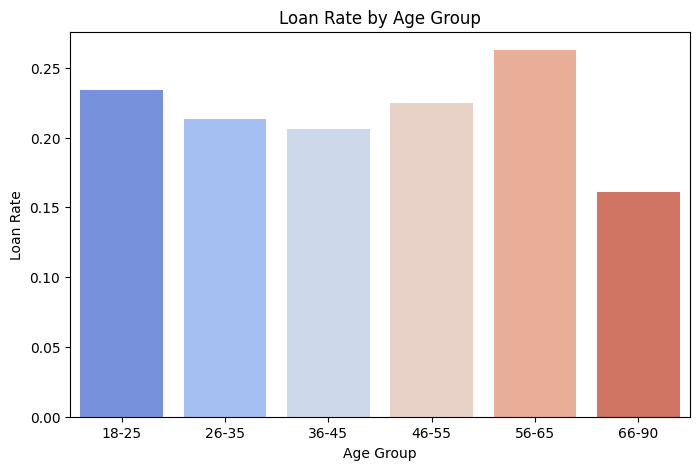

In [11]:
#which factor affects loan most 
#Age vs loan_status
bins = [18, 25, 35, 45, 55, 65, 90]
labels = ['18-25', '26-35', '36-45', '46-55', '56-65', '66-90']
clean_load_data['Age Group'] = pd.cut(clean_load_data['person_age'], bins=bins, labels=labels)

# Calculate loan rate per age group
age_loan = clean_load_data.groupby('Age Group')['loan_status'].mean()

# Plot churn rate by age group
plt.figure(figsize=(8, 5))
sns.barplot(x=age_loan.index, y=age_loan.values, palette='coolwarm')
plt.title("Loan Rate by Age Group")
plt.ylabel("Loan Rate")
plt.show()

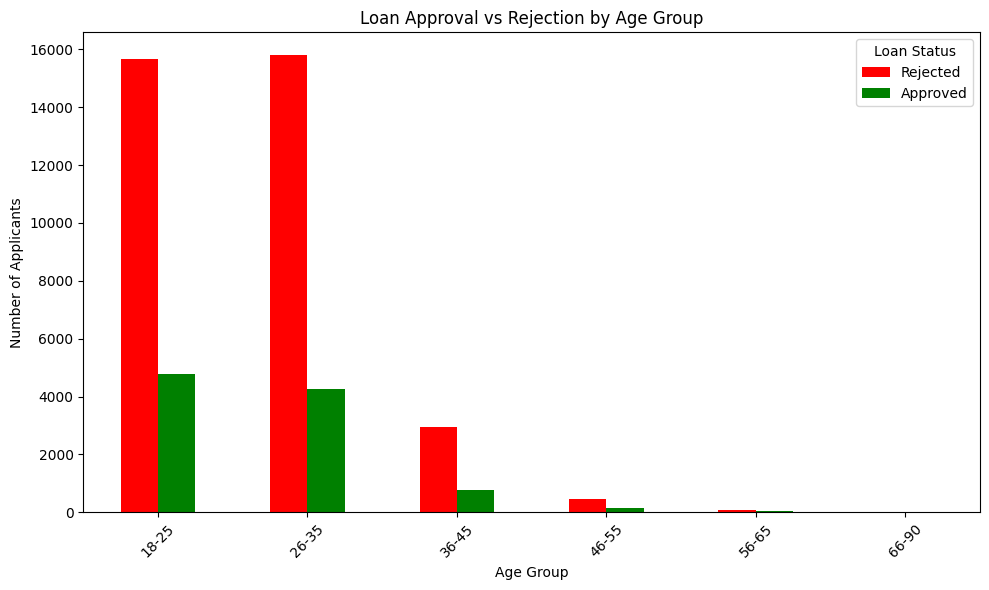

In [12]:
# Create Age Group column
clean_load_data['Age Group'] = pd.cut(clean_load_data['person_age'], bins=bins, labels=labels)

# Group by Age Group and loan_status, then count
grouped = clean_load_data.groupby(['Age Group', 'loan_status']).size().reset_index(name='count')

# Pivot to make loan_status values separate columns
pivot_df = grouped.pivot(index='Age Group', columns='loan_status', values='count').fillna(0)

# Optional: rename columns for clarity
pivot_df.columns = ['Rejected', 'Approved']  # loan_status 0 = rejected, 1 = approved

# Reset index for plotting
pivot_df = pivot_df.reset_index()

# Plotting
pivot_df.plot(x='Age Group', kind='bar', stacked=False, color=['red', 'green'], figsize=(10, 6))
plt.title('Loan Approval vs Rejection by Age Group')
plt.ylabel('Number of Applicants')
plt.xlabel('Age Group')
plt.xticks(rotation=45)
plt.legend(title='Loan Status')
plt.tight_layout()
plt.show()

['female' 'male']


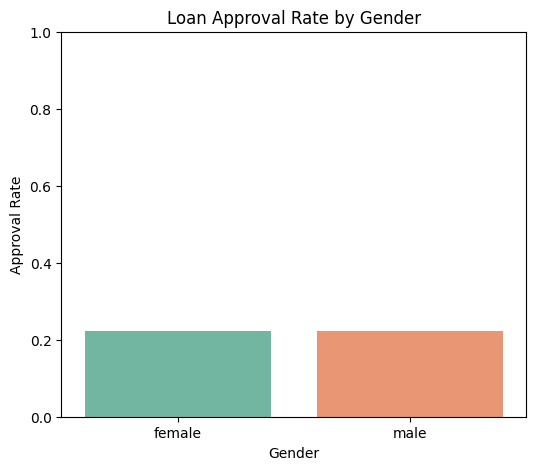

In [13]:
#How gender affects loan approval 
print(clean_load_data['person_gender'].unique())

loan_by_gender = clean_load_data.groupby('person_gender')['loan_status'].mean()

plt.figure(figsize = (6,5))
sns.barplot(x = loan_by_gender.index, y = loan_by_gender.values, palette = 'Set2')
plt.title('Loan Approval Rate by Gender')
plt.ylabel('Approval Rate')
plt.xlabel('Gender')
plt.ylim(0,1)
plt.show()

The approval rates for male and female applicants are almost identical, suggesting that gender does not have a substantial influence on loan decisions in this dataset.

Object `loan_rate` not found.


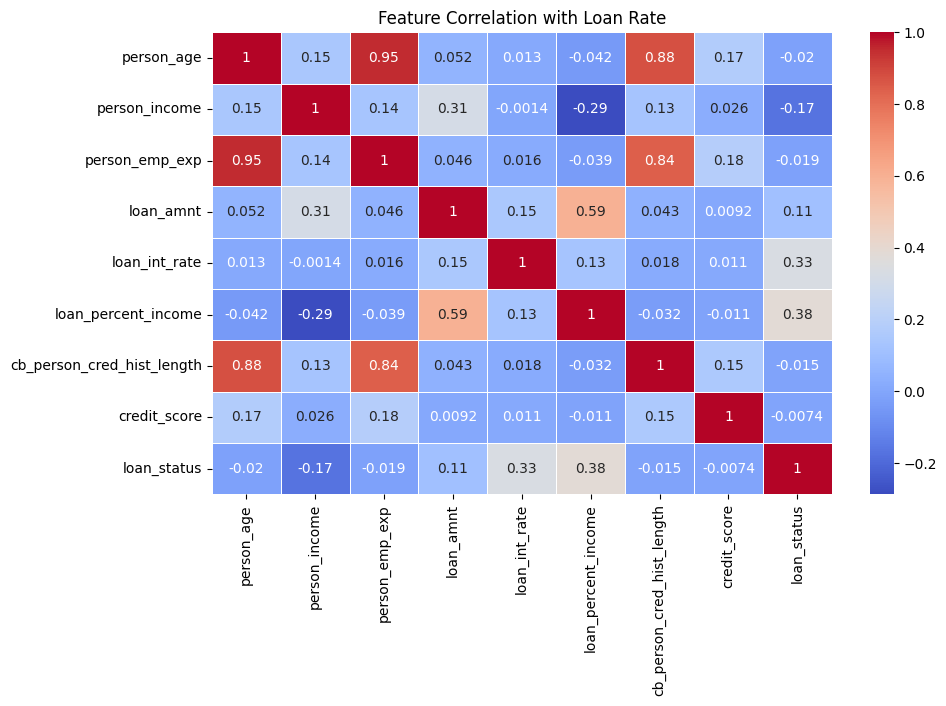

In [14]:
Which features are most correlated with loan_rate?
plt.figure(figsize=(10,6))
sns.heatmap(clean_load_data.select_dtypes(include=["number"]).corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation with Loan Rate")
plt.show()

Most important features for predicting loan_status in this correlation matrix:
i.loan_percent_income (0.38)

ii.loan_int_rate (0.33)

iii.loan_amnt (0.11)

Least important / negligible:
age, employment experience, credit score, credit history length

In [15]:
#Feature Importance with Random Forest
#X = clean_load_data.drop(columns=['loan_status'])  # Features
#y = clean_load_data['loan_status']                # Target

# 2. Convert categorical variables (if any)
#X = pd.get_dummies(X, drop_first=True)

# 3. Split the dataset
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Train Random Forest model
#rf = RandomForestClassifier(n_estimators=100, random_state=42)
#rf.fit(X_train, y_train)

# 5. Get feature importances
#importances = rf.feature_importances_
#features = X.columns

# 6. Create DataFrame of importances
#feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances})
#feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# 7. Plot feature importance
#plt.figure(figsize=(10, 6))
#sns.barplot(data=feat_imp_df.head(10), x='Importance', y='Feature', palette='viridis')
#plt.title('Top 10 Feature Importances - Random Forest')
#plt.tight_layout()
#plt.show()


1.previous_loan_defaults_on_file_Yes (Most Important)
Meaning: Whether the applicant defaulted on a previous loan has the strongest influence on approval.
Makes sense — prior defaults are red flags in credit risk.

2.loan_percent_income
Definition: How much of a person's income goes toward repaying the loan.
A higher value likely means a riskier borrower, so this is a strong predictor.

3.loan_int_rate
Loan interest rate — the higher it is, the riskier the borrower appears.

4.person_income
Higher income likely increases chances of loan approval.

5.loan_amnt
The loan amount requested. Larger loans may be harder to approve unless well justified.

6.credit_score
Still important, but less so than defaults, income ratio, or interest rate — interesting insight!

7.person_home_ownership_RENT
Renters may be viewed as less stable than homeowners.

8.8–10. person_age, person_emp_exp, cb_person_cred_hist_length
These play a minor role, though still useful for context.

This reveals that credit history and affordability (not age or employment alone) are the biggest drivers of loan approval — a practical and explainable result in financial services.

Based on the histograms you’ve shared, we typically apply log transformation to highly right-skewed (long tail to the right) distributions to normalize them and improve model performance.

## Creating New Feature 

#Before taking log transform lets see if we can create new features 
i. debt_to_income_ration:  This is arguably the most crucial financial metric. It directly shows how much of a person's income is tied up in loan payments. A higher ratio indicates higher risk. loan_percent_income is a good start, but a direct loan_amnt / person_income might provide a different perspective.

ii. income_per_employment_year: This feature attempts to capture the "quality" or stability of income relative to a person's work experience. A high income with very little experience might be different from a high income with substantial experience. It can also indicate career progression.

iii. This feature connects the requested loan size to the duration of the borrower's credit history. A very large loan relative to a short credit history could signal higher risk, as there's less data to assess their long-term repayment behavior.

In [16]:
clean_load_data

person_age person_gender person_education  person_income  \
0            22.0        female           Master        71948.0   
1            21.0        female      High School        12282.0   
2            25.0        female      High School        12438.0   
3            23.0        female         Bachelor        79753.0   
4            24.0          male           Master        66135.0   
...           ...           ...              ...            ...   
44995        27.0          male        Associate        47971.0   
44996        37.0        female        Associate        65800.0   
44997        33.0          male        Associate        56942.0   
44998        29.0          male         Bachelor        33164.0   
44999        24.0          male      High School        51609.0   

       person_emp_exp person_home_ownership  loan_amnt        loan_intent  \
0                   0                  RENT    35000.0           PERSONAL   
1                   0                   OWN     1000.0          EDUCATION   
2                   3              MORTGAGE     5500.0            MEDICAL   
3                   0                  RENT    35000.0            MEDICAL   
4                   1                  RENT    35000.0            MEDICAL   
...               ...                   ...        ...                ...   
44995               6                  RENT    15000.0            MEDICAL   
44996              17                  RENT     9000.0    HOMEIMPROVEMENT   
44997               7                  RENT     2771.0  DEBTCONSOLIDATION   
44998               4                  RENT    12000.0          EDUCATION   
44999               1                  RENT     6665.0  DEBTCONSOLIDATION   

       loan_int_rate  loan_percent_income  cb_person_cred_hist_length  \
0              16.02                 0.49                         3.0   
1              11.14                 0.08                         2.0   
2              12.87                 0.44                         3.0   
3              15.23                 0.44                         2.0   
4              14.27                 0.53                         4.0   
...              ...                  ...                         ...   
44995          15.66                 0.31                         3.0   
44996          14.07                 0.14                        11.0   
44997          10.02                 0.05                        10.0   
44998          13.23                 0.36                         6.0   
44999          17.05                 0.13                         3.0   

       credit_score previous_loan_defaults_on_file  loan_status Age Group  
0               561                             No            1     18-25  
1               504                            Yes            0     18-25  
2               635                             No            1     18-25  
3               675                             No            1     18-25  
4               586                             No            1     18-25  
...             ...                            ...          ...       ...  
44995           645                             No            1     26-35  
44996           621                             No            1     36-45  
44997           668                             No            1     26-35  
44998           604                             No            1     26-35  
44999           628                             No            1     18-25  

[44992 rows x 15 columns]

In [17]:
clean_load_data["debt_to_income_ratio"] = clean_load_data["loan_amnt"]/ clean_load_data["person_income"]
clean_load_data["income_per_employment_year"] = clean_load_data["person_income"] / (clean_load_data["person_emp_exp"] + 1)
clean_load_data['loan_amnt_per_credit_hist_year'] = clean_load_data['loan_amnt'] / (clean_load_data['cb_person_cred_hist_length'] + 1)
# 4. Credit Score x Loan Interest Rate Interaction
clean_load_data['credit_score_x_loan_int_rate'] = clean_load_data['credit_score'] * clean_load_data['loan_int_rate']

In [18]:
clean_load_data

person_age person_gender person_education  person_income  \
0            22.0        female           Master        71948.0   
1            21.0        female      High School        12282.0   
2            25.0        female      High School        12438.0   
3            23.0        female         Bachelor        79753.0   
4            24.0          male           Master        66135.0   
...           ...           ...              ...            ...   
44995        27.0          male        Associate        47971.0   
44996        37.0        female        Associate        65800.0   
44997        33.0          male        Associate        56942.0   
44998        29.0          male         Bachelor        33164.0   
44999        24.0          male      High School        51609.0   

       person_emp_exp person_home_ownership  loan_amnt        loan_intent  \
0                   0                  RENT    35000.0           PERSONAL   
1                   0                   OWN     1000.0          EDUCATION   
2                   3              MORTGAGE     5500.0            MEDICAL   
3                   0                  RENT    35000.0            MEDICAL   
4                   1                  RENT    35000.0            MEDICAL   
...               ...                   ...        ...                ...   
44995               6                  RENT    15000.0            MEDICAL   
44996              17                  RENT     9000.0    HOMEIMPROVEMENT   
44997               7                  RENT     2771.0  DEBTCONSOLIDATION   
44998               4                  RENT    12000.0          EDUCATION   
44999               1                  RENT     6665.0  DEBTCONSOLIDATION   

       loan_int_rate  loan_percent_income  cb_person_cred_hist_length  \
0              16.02                 0.49                         3.0   
1              11.14                 0.08                         2.0   
2              12.87                 0.44                         3.0   
3              15.23                 0.44                         2.0   
4              14.27                 0.53                         4.0   
...              ...                  ...                         ...   
44995          15.66                 0.31                         3.0   
44996          14.07                 0.14                        11.0   
44997          10.02                 0.05                        10.0   
44998          13.23                 0.36                         6.0   
44999          17.05                 0.13                         3.0   

       credit_score previous_loan_defaults_on_file  loan_status Age Group  \
0               561                             No            1     18-25   
1               504                            Yes            0     18-25   
2               635                             No            1     18-25   
3               675                             No            1     18-25   
4               586                             No            1     18-25   
...             ...                            ...          ...       ...   
44995           645                             No            1     26-35   
44996           621                             No            1     36-45   
44997           668                             No            1     26-35   
44998           604                             No            1     26-35   
44999           628                             No            1     18-25   

       debt_to_income_ratio  income_per_employment_year  \
0                  0.486462                71948.000000   
1                  0.081420                12282.000000   
2                  0.442193                 3109.500000   
3                  0.438855                79753.000000   
4                  0.529221                33067.500000   
...                     ...                         ...   
44995              0.312689                 6853.000000   
449

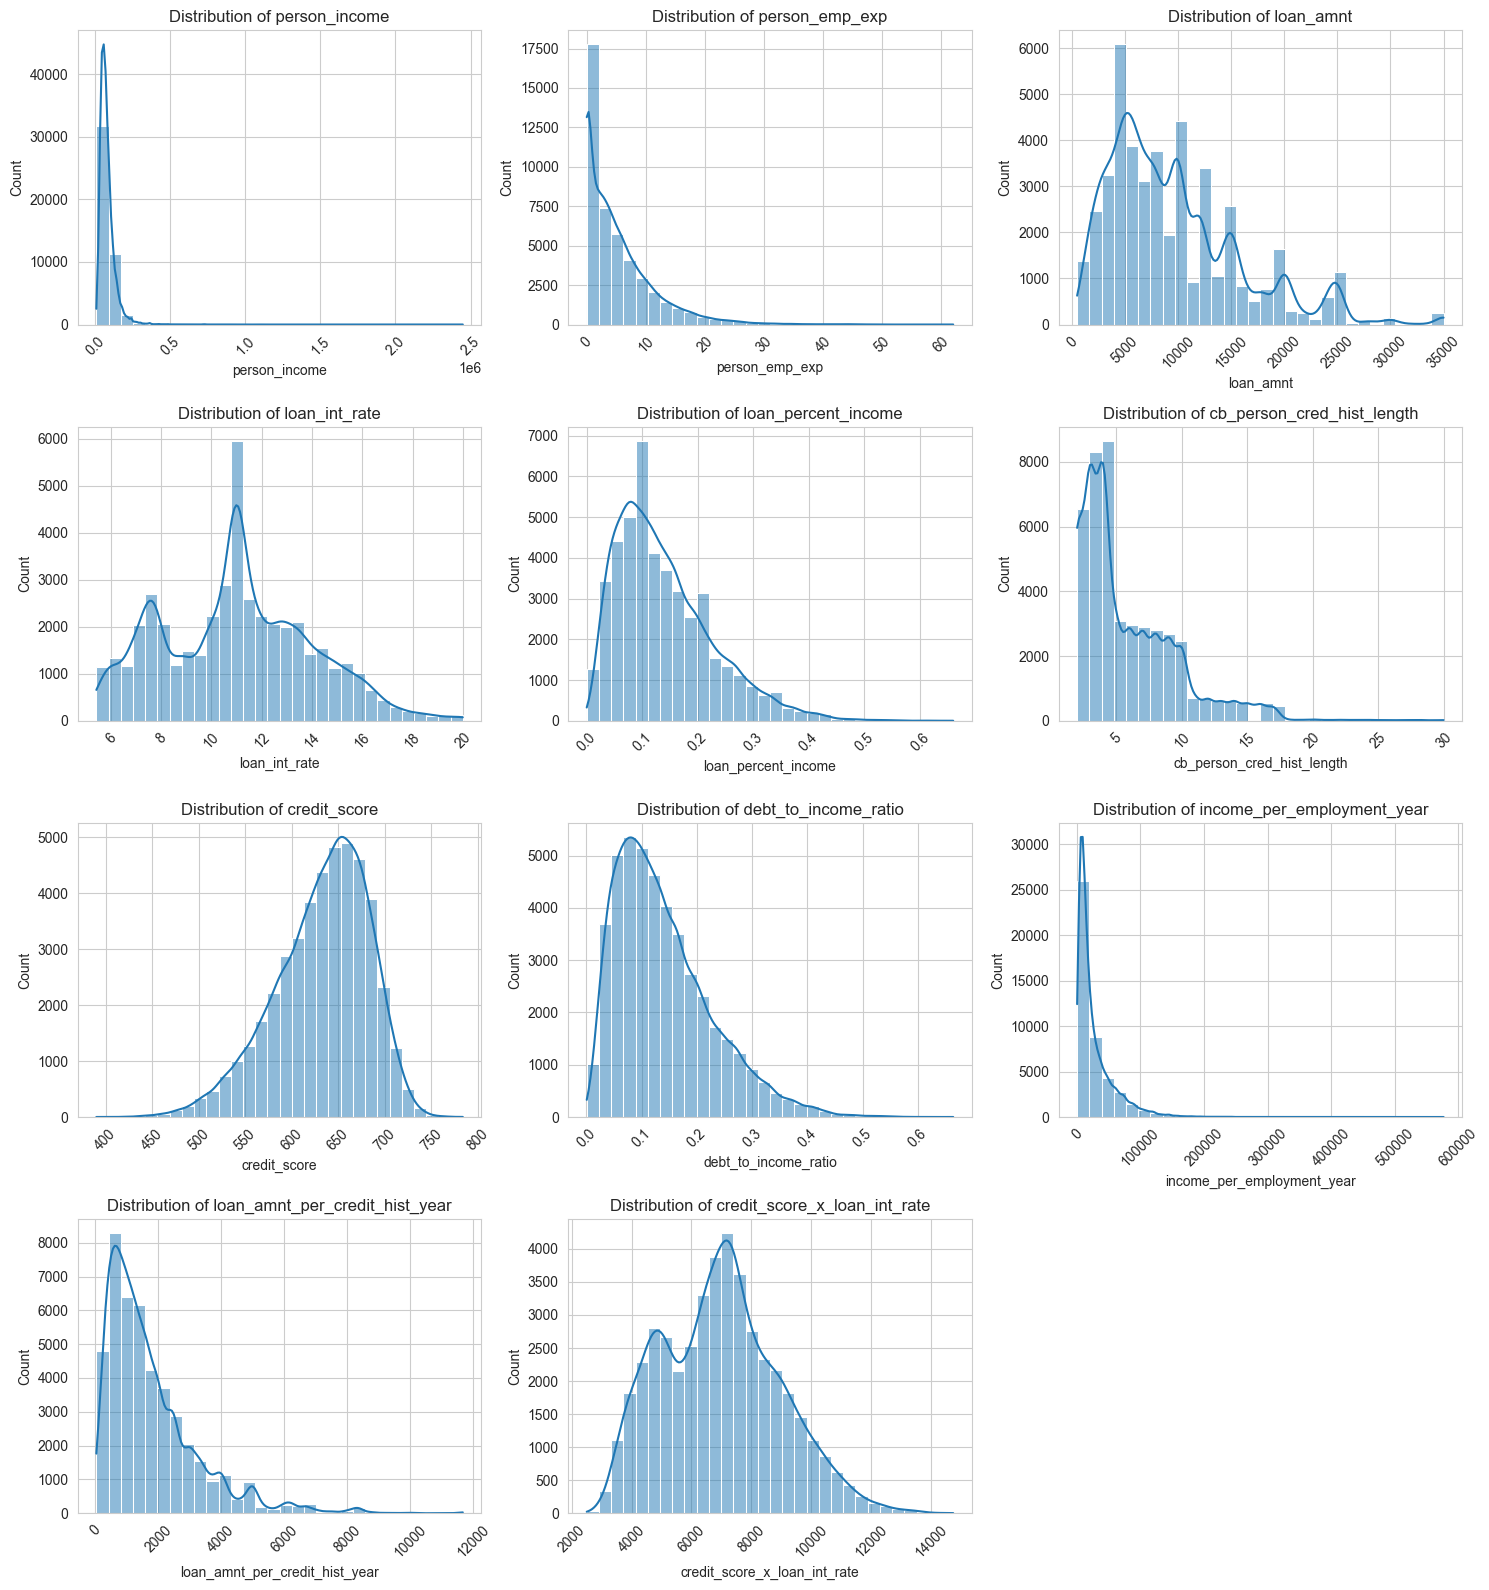

In [19]:
# distribution of num cols
num_cols = ["person_income", "person_emp_exp", "loan_amnt", "loan_int_rate",
            "loan_percent_income", "cb_person_cred_hist_length", "credit_score",
            "debt_to_income_ratio", "income_per_employment_year",
            "loan_amnt_per_credit_hist_year", "credit_score_x_loan_int_rate"]

# Visualizing the Distributions
# Set style
sns.set_style("whitegrid")

# Calculate the number of rows and columns needed dynamically
n_features = len(num_cols)
n_cols = 3 # You can keep this at 3 or 4, depends on how wide you want it
n_rows = (n_features + n_cols - 1) // n_cols # Integer division to get ceiling

# Create subplots for histograms
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 5, n_rows * 4)) # Adjust figsize dynamically

axes = axes.flatten() # Flatten the axes array for easy iteration

for i, col in enumerate(num_cols):
    # Ensure we don't try to plot if there are more features than available subplots (shouldn't happen with dynamic calculation)
    if i < len(axes): # This check is good practice but less critical with dynamic row/col calculation
        sns.histplot(clean_load_data[col], bins=30, kde=True, ax=axes[i])  # Histogram with density curve
        axes[i].set_title(f"Distribution of {col}", fontsize=12) # Added fontsize for better readability
        axes[i].tick_params(axis='x', rotation=45)

# Hide any unused subplots if n_features is not a perfect multiple of n_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Based on the histograms you’ve shared, we typically apply log transformation to highly right-skewed (long tail to the right) distributions to normalize them and improve model performance.

In [20]:
cols_to_log = ['person_income', 'person_emp_exp', 'loan_amnt', 'loan_percent_income', 'cb_person_cred_hist_length', 'income_per_employment_year', 'loan_amnt_per_credit_hist_year']

for col in cols_to_log:
    clean_load_data[f'{col}_log'] = np.log1p(clean_load_data[col])

In [21]:
clean_load_data.head()

person_age person_gender person_education  person_income  person_emp_exp  \
0        22.0        female           Master        71948.0               0   
1        21.0        female      High School        12282.0               0   
2        25.0        female      High School        12438.0               3   
3        23.0        female         Bachelor        79753.0               0   
4        24.0          male           Master        66135.0               1   

  person_home_ownership  loan_amnt loan_intent  loan_int_rate  \
0                  RENT    35000.0    PERSONAL          16.02   
1                   OWN     1000.0   EDUCATION          11.14   
2              MORTGAGE     5500.0     MEDICAL          12.87   
3                  RENT    35000.0     MEDICAL          15.23   
4                  RENT    35000.0     MEDICAL          14.27   

   loan_percent_income  ...  income_per_employment_year  \
0                 0.49  ...                     71948.0   
1                 0.08  ...                     12282.0   
2                 0.44  ...                      3109.5   
3                 0.44  ...                     79753.0   
4                 0.53  ...                     33067.5   

   loan_amnt_per_credit_hist_year credit_score_x_loan_int_rate  \
0                     8750.000000                      8987.22   
1                      333.333333                      5614.56   
2                     1375.000000                      8172.45   
3                    11666.666667                     10280.25   
4                     7000.000000                      8362.22   

   person_income_log person_emp_exp_log  loan_amnt_log  \
0          11.183713           0.000000      10.463132   
1           9.415971           0.000000       6.908755   
2           9.428592           1.386294       8.612685   
3          11.286702           0.000000      10.463132   
4          11.099469           0.693147      10.463132   

   loan_percent_income_log  cb_person_cred_hist_length_log  \
0                 0.398776                        1.386294   
1                 0.076961                        1.098612   
2                 0.364643                        1.386294   
3                 0.364643                        1.098612   
4                 0.425268                        1.609438   

   income_per_employment_year_log  loan_amnt_per_credit_hist_year_log  
0                       11.183713                            9.076923  
1                        9.415971                            5.812138  
2                        8.042539                            7.226936  
3                       11.286702                            9.364577  
4                       10.406336                            8.853808  

[5 rows x 26 columns]

 Drop the original skewed columns to avoid multicollinearity.

In [22]:
# List of columns that you just log-transformed
cols_to_log = ['person_income', 'person_emp_exp', 'loan_amnt', 'loan_percent_income',
               'cb_person_cred_hist_length', 'income_per_employment_year',
               'loan_amnt_per_credit_hist_year']

# Drop the original columns (now that you have their _log versions)
clean_load_data = clean_load_data.drop(columns=cols_to_log)

# Verify the new columns and count
print(f"Shape after dropping original columns: {clean_load_data.shape}")
print(clean_load_data.columns)

Shape after dropping original columns: (44992, 19)
Index(['person_age', 'person_gender', 'person_education',
       'person_home_ownership', 'loan_intent', 'loan_int_rate', 'credit_score',
       'previous_loan_defaults_on_file', 'loan_status', 'Age Group',
       'debt_to_income_ratio', 'credit_score_x_loan_int_rate',
       'person_income_log', 'person_emp_exp_log', 'loan_amnt_log',
       'loan_percent_income_log', 'cb_person_cred_hist_length_log',
       'income_per_employment_year_log', 'loan_amnt_per_credit_hist_year_log'],
      dtype='object')


In [23]:
clean_load_data

person_age person_gender person_education person_home_ownership  \
0            22.0        female           Master                  RENT   
1            21.0        female      High School                   OWN   
2            25.0        female      High School              MORTGAGE   
3            23.0        female         Bachelor                  RENT   
4            24.0          male           Master                  RENT   
...           ...           ...              ...                   ...   
44995        27.0          male        Associate                  RENT   
44996        37.0        female        Associate                  RENT   
44997        33.0          male        Associate                  RENT   
44998        29.0          male         Bachelor                  RENT   
44999        24.0          male      High School                  RENT   

             loan_intent  loan_int_rate  credit_score  \
0               PERSONAL          16.02           561   
1              EDUCATION          11.14           504   
2                MEDICAL          12.87           635   
3                MEDICAL          15.23           675   
4                MEDICAL          14.27           586   
...                  ...            ...           ...   
44995            MEDICAL          15.66           645   
44996    HOMEIMPROVEMENT          14.07           621   
44997  DEBTCONSOLIDATION          10.02           668   
44998          EDUCATION          13.23           604   
44999  DEBTCONSOLIDATION          17.05           628   

      previous_loan_defaults_on_file  loan_status Age Group  \
0                                 No            1     18-25   
1                                Yes            0     18-25   
2                                 No            1     18-25   
3                                 No            1     18-25   
4                                 No            1     18-25   
...                              ...          ...       ...   
44995                             No            1     26-35   
44996                             No            1     36-45   
44997                             No            1     26-35   
44998                             No            1     26-35   
44999                             No            1     18-25   

       debt_to_income_ratio  credit_score_x_loan_int_rate  person_income_log  \
0                  0.486462                       8987.22          11.183713   
1                  0.081420                       5614.56           9.415971   
2                  0.442193                       8172.45           9.428592   
3                  0.438855                      10280.25          11.286702   
4                  0.529221                       8362.22          11.099469   
...                     ...                           ...                ...   
44995              0.312689                      10100.70          10.778373   
44996              0.136778                       8737.47          11.094390   
44997              0.048664                       6693.36          10.949806   
44998              0.361838                       7990.92          10.409250   
44999              0.129144                      10707.40          10.851471   

       person_emp_exp_log  loan_amnt_log  loan_percent_income_log  \
0                0.000000      10.463132                 0.398776   
1                0.000000       6.908755                 0.076961   
2                1.386294       8.612685                 0.364643   
3                0.000000      10.463132                 0.364643   
4                0.693147      10.463132                 0.425268   
...                   ...            ...                      ...   
44995            1.945910       9.615872                 0.270027   
44996            2.890372       9.105091                 0.131028   
44997            2.079442       7.927324                 0.048790   
44998            1.609438

In [24]:
#split into training and test sets
# Define features (X) and target variable (y)
X = clean_load_data.drop(columns=['loan_status', 'person_age']) #because we created Age Group above and CustomerID is just an identifier
y = clean_load_data['loan_status']

In [25]:
X

person_gender person_education person_home_ownership        loan_intent  \
0            female           Master                  RENT           PERSONAL   
1            female      High School                   OWN          EDUCATION   
2            female      High School              MORTGAGE            MEDICAL   
3            female         Bachelor                  RENT            MEDICAL   
4              male           Master                  RENT            MEDICAL   
...             ...              ...                   ...                ...   
44995          male        Associate                  RENT            MEDICAL   
44996        female        Associate                  RENT    HOMEIMPROVEMENT   
44997          male        Associate                  RENT  DEBTCONSOLIDATION   
44998          male         Bachelor                  RENT          EDUCATION   
44999          male      High School                  RENT  DEBTCONSOLIDATION   

       loan_int_rate  credit_score previous_loan_defaults_on_file Age Group  \
0              16.02           561                             No     18-25   
1              11.14           504                            Yes     18-25   
2              12.87           635                             No     18-25   
3              15.23           675                             No     18-25   
4              14.27           586                             No     18-25   
...              ...           ...                            ...       ...   
44995          15.66           645                             No     26-35   
44996          14.07           621                             No     36-45   
44997          10.02           668                             No     26-35   
44998          13.23           604                             No     26-35   
44999          17.05           628                             No     18-25   

       debt_to_income_ratio  credit_score_x_loan_int_rate  person_income_log  \
0                  0.486462                       8987.22          11.183713   
1                  0.081420                       5614.56           9.415971   
2                  0.442193                       8172.45           9.428592   
3                  0.438855                      10280.25          11.286702   
4                  0.529221                       8362.22          11.099469   
...                     ...                           ...                ...   
44995              0.312689                      10100.70          10.778373   
44996              0.136778                       8737.47          11.094390   
44997              0.048664                       6693.36          10.949806   
44998              0.361838                       7990.92          10.409250   
44999              0.129144                      10707.40          10.851471   

       person_emp_exp_log  loan_amnt_log  loan_percent_income_log  \
0                0.000000      10.463132                 0.398776   
1                0.000000       6.908755                 0.076961   
2                1.386294       8.612685                 0.364643   
3                0.000000      10.463132                 0.364643   
4                0.693147      10.463132                 0.425268   
...                   ...            ...                      ...   
44995            1.945910       9.615872                 0.270027   
44996            2.890372       9.105091                 0.131028   
44997            2.079442       7.927324                 0.048790   
44998            1.609438       9.392745                 0.307485   
44999            0.693147       8.804775                 0.122218   

       cb_person_cred_hist_length_log  income_per_employment_year_log  \
0                            1.386294                       11.183713   
1                            1.098612                        9.415971   
2                            1.386294                        8.042539   
3 

In [26]:
y

0        1
1        0
2        1
3        1
4        1
        ..
44995    1
44996    1
44997    1
44998    1
44999    1
Name: loan_status, Length: 44992, dtype: int64

In [27]:
#Split into train, validation and test 
# First split: Train+Eval and Test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y)

# Second split: Train and Eval (from temp)
X_train, X_eval, y_train, y_eval = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp)  # 0.176 ≈ 15% of original data

# Confirm the shapes
print(f"Train shape: {X_train.shape}")
print(f"Eval shape: {X_eval.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (31512, 17)
Eval shape: (6731, 17)
Test shape: (6749, 17)


In [28]:
# Identify all numerical and categorical columns
numerical_cols = [
    'loan_int_rate',
    'credit_score',
    'debt_to_income_ratio',
    'credit_score_x_loan_int_rate',
    'person_income_log',
    'person_emp_exp_log',
    'loan_amnt_log',
    'loan_percent_income_log',
    'cb_person_cred_hist_length_log',
    'income_per_employment_year_log',
    'loan_amnt_per_credit_hist_year_log'
]
categorical_cols = [
    'person_gender',
    'person_education',
    'person_home_ownership',
    'loan_intent',
    'previous_loan_defaults_on_file',
    'Age Group'
]

# Define preprocessing for numerical data (Imputation + Scaling)
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Use median to handle outliers
    ('scaler', StandardScaler())  # Scale numerical features
])
# Define preprocessing for categorical data (Imputation + Encoding)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing categorical values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Convert categorical values to numeric
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),  # Process all num cols
        ('cat', categorical_transformer, categorical_cols)  # Process all cat cols
    ]
)

In [29]:
X_train_processed = preprocessor.fit_transform(X_train)
X_eval_processed = preprocessor.transform(X_eval)
X_test_processed = preprocessor.transform(X_test)

#Convert to DataFrame 
X_train_processed =  pd.DataFrame(X_train_processed)
X_eval_processed = pd.DataFrame(X_eval_processed)
X_test_processed = pd.DataFrame(X_test_processed)

In [30]:
X_train_processed

0         1         2         3         4         5         6   \
0     -0.002760 -1.600927  0.891341 -0.452213 -1.319891  0.528751 -0.116263   
1      0.829415  1.793504 -1.012959  1.404954  0.974192 -1.491274 -0.332737   
2      0.829415  0.900233 -0.783196  1.098243 -0.576422 -0.771727 -1.089602   
3     -1.355046  1.138438 -0.990764 -1.089493 -0.006950  0.997951 -1.050047   
4     -0.345026 -0.429749 -0.660590 -0.438889 -0.258455  0.179463 -0.646089   
...         ...       ...       ...       ...       ...       ...       ...   
31507 -0.740981 -0.012889  0.012693 -0.709688 -1.146900  0.368729 -0.588765   
31508  0.661638  0.245167 -1.276414  0.710379 -1.191265 -1.491274 -2.848133   
31509  1.248858  0.999485  1.307265  1.563678 -1.871996 -1.491274 -0.332737   
31510 -1.093313  1.634700  1.012433 -0.719550 -1.382777 -0.771727 -0.099115   
31511 -0.217515  0.602476  0.279784 -0.049131  1.992902  1.319919  2.085521   

             7         8         9   ...   26   27   28   29   30   31   32  \
0      0.964573  1.015692 -1.190756  ...  0.0  0.0  0.0  1.0  0.0  1.0  0.0   
1     -1.070044 -0.812290  1.892752  ...  0.0  0.0  0.0  1.0  1.0  0.0  0.0   
2     -0.814213 -0.812290  0.403172  ...  0.0  0.0  1.0  0.0  1.0  0.0  0.0   
3     -1.070044  0.570525 -0.922633  ...  0.0  0.0  1.0  0.0  0.0  1.0  0.0   
4     -0.688085 -1.386210 -0.303124  ...  0.0  0.0  0.0  1.0  1.0  0.0  0.0   
...         ...       ...       ...  ...  ...  ...  ...  ...  ...  ...  ...   
31507  0.044992 -0.367123 -0.951179  ...  0.0  0.0  0.0  1.0  1.0  0.0  0.0   
31508 -1.330794 -0.367123  0.737848  ...  0.0  0.0  1.0  0.0  1.0  0.0  0.0   
31509  1.293949 -0.812290  0.374793  ...  0.0  0.0  1.0  0.0  1.0  0.0  0.0   
31510  1.075256 -0.812290 -0.026871  ...  0.0  0.0  1.0  0.0  1.0  0.0  0.0   
31511  0.280800  1.015692 -0.152618  ...  1.0  0.0  1.0  0.0  0.0  1.0  0.0   

        33   34   35  
0      0.0  0.0  0.0  
1      0.0  0.0  0.0  
2      0.0  0.0  0.0  
3      0.0  0.0  0.0  
4      0.0  0.0  0.0  
...    ...  ...  ...  
31507  0.0  0.0  0.0  
31508  0.0  0.0  0.0  
31509  0.0  0.0  0.0  
31510  0.0  0.0  0.0  
31511  0.0  0.0  0.0  

[31512 rows x 36 columns]

In [31]:
#checking the class distribution in the training data
print(y_train.value_counts(normalize=True))

loan_status
0    0.777735
1    0.222265
Name: proportion, dtype: float64


In [32]:
#addressing imbalance
smote = SMOTE(random_state=42)

# Fit and resample only the training data
X_resampled, y_resampled = smote.fit_resample(X_train_processed, y_train)

# Check new class distribution
print(y_resampled.value_counts(normalize=True))

loan_status
0    0.5
1    0.5
Name: proportion, dtype: float64


In [33]:
# Initialize the model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Fit on training data
log_reg.fit(X_train_processed, y_train)

LogisticRegression(max_iter=1000, random_state=42)

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.94      5235
           1       0.79      0.76      0.77      1496

    accuracy                           0.90      6731
   macro avg       0.86      0.85      0.85      6731
weighted avg       0.90      0.90      0.90      6731

Confusion Matrix:
 [[4927  308]
 [ 365 1131]]
ROC AUC Score: 0.958


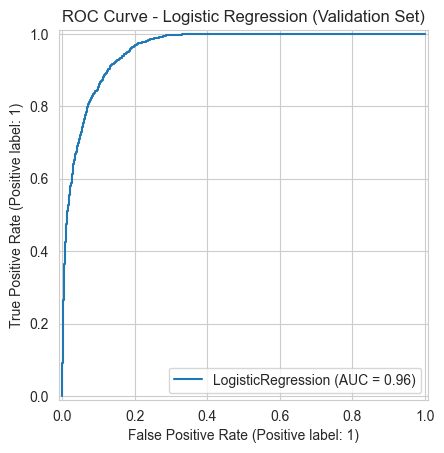

In [34]:
# Predict class and probability
y_eval_pred = log_reg.predict(X_eval_processed)
y_eval_proba = log_reg.predict_proba(X_eval_processed)[:, 1]

# Metrics
print("Classification Report:\n", classification_report(y_eval, y_eval_pred))
print("Confusion Matrix:\n", confusion_matrix(y_eval, y_eval_pred))
print(f"ROC AUC Score: {roc_auc_score(y_eval, y_eval_proba):.3f}")

# ROC Curve
RocCurveDisplay.from_estimator(log_reg, X_eval_processed, y_eval)
plt.title("ROC Curve - Logistic Regression (Validation Set)")
plt.show()

## Results of trial models

Before Log of num_cols results:
True Negatives (TN): 2953 — Model correctly predicted loans not approved.

False Positives (FP): 539 — Model incorrectly approved loans that shouldn't have been approved.

False Negatives (FN): 88 — Model missed predicting some approved loans.

True Positives (TP): 920 — Model correctly predicted loans that should be approved.


Performance Metrics
Metric Class 0 (Not Approved)	Class 1 (Approved)	What it Means
Precision	0.97	0.63	Of loans predicted as approved, only 63% were correct. High false positives.
Recall	0.85	0.91	91% of actual approved loans were correctly identified — great recall!
F1 Score	0.90	0.75	Balance between precision and recall. Class 1 is decent but can improve.
Accuracy	0.86	—	86% overall accuracy across all classes.
ROC AUC	0.95	—	Excellent — your model distinguishes well between approved and not approved.


After log , The results did not change significantly.

After dropping two features and divding the data into train, validation , test

In [35]:
models = {
    "Logistic Regression": LogisticRegression(solver='liblinear', penalty='l2'),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

In [36]:
for name, model in models.items():
    model.fit(X_train_processed, y_train)  # assuming X_train_processed is already scaled/encoded
    y_pred = model.predict(X_eval_processed)
    y_proba = model.predict_proba(X_eval_processed)[:, 1]
    
    print(f"\nModel: {name}")
    print(classification_report(y_eval, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_eval, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_eval, y_proba))


Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      5235
           1       0.79      0.76      0.77      1496

    accuracy                           0.90      6731
   macro avg       0.86      0.85      0.85      6731
weighted avg       0.90      0.90      0.90      6731

Confusion Matrix:
 [[4926  309]
 [ 365 1131]]
ROC AUC Score: 0.9579616321652391

Model: Random Forest
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      5235
           1       0.89      0.76      0.82      1496

    accuracy                           0.93      6731
   macro avg       0.91      0.87      0.89      6731
weighted avg       0.92      0.93      0.92      6731

Confusion Matrix:
 [[5093  142]
 [ 356 1140]]
ROC AUC Score: 0.9730590712450649

Model: Decision Tree
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      5235
     

It has the highest precision and F1-score for Class 1 (defaulters).

Its recall for Class 1 is competitive with Logistic Regression (0.76 vs 0.76) but it achieves this with much higher precision (0.89 vs 0.79), meaning its predictions for defaulters are much more reliable.

Its ROC AUC score of 0.9731 is excellent and indicates superior overall discriminative power.

The confusion matrix shows a very good balance: low False Positives (denying good loans) and improved False Negatives (missing actual defaulters).

In [37]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42)

# Set up Grid Search
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='roc_auc',      # Optimize for ROC AUC
    cv=3,                   # 3-fold cross-validation
    verbose=2,
    n_jobs=-1               # Use all cores
)

# Fit on processed training data
grid_search.fit(X_train_processed, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, None],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='roc_auc', verbose=2)

In [38]:
# Best model from the grid
best_rf = grid_search.best_estimator_

# Predict
y_pred = best_rf.predict(X_eval_processed)
y_proba = best_rf.predict_proba(X_eval_processed)[:, 1]

# Evaluate
print("Best Parameters:", grid_search.best_params_)
print(classification_report(y_eval, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_eval, y_pred))
print("ROC AUC Score:", roc_auc_score(y_eval, y_proba))

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      5235
           1       0.89      0.76      0.82      1496

    accuracy                           0.93      6731
   macro avg       0.91      0.87      0.89      6731
weighted avg       0.93      0.93      0.92      6731

Confusion Matrix:
 [[5095  140]
 [ 355 1141]]
ROC AUC Score: 0.9741399542364484


After Hyperparameter Tuning
ROC AUC Score: 0.9741  (Slightly higher — better separability)

Recall (Class 1): 0.76 (Same — still catching 76% of true approvals)

Precision (Class 1): 0.89  (Same)

Accuracy: 0.93  (Same)

Confusion Matrix: 355 false negatives, 140 false positives (Slightly fewer errors)

Conclusion
The performance did improve slightly in terms of:

ROC AUC: Better model confidence across all thresholds

Confusion Matrix: Fewer false positives and negatives

However, the overall metrics remained similar, which means:

Your original model was already well-tuned.

Grid search helped fine-tune it a bit more.

In [39]:
# Sample from the original (unprocessed) evaluation set
#sample_data_raw = X_eval.sample(n=100, random_state=42)

# Transform using the same preprocessor
#sample_data_processed = preprocessor.transform(sample_data_raw)

#feature_names = preprocessor.get_feature_names_out()

# Step 4: Wrap into DataFrame
#sample_data_df = pd.DataFrame(sample_data_processed.toarray() 
#                              if hasattr(sample_data_processed, 'toarray') 
#                              else sample_data_processed,
#                              columns=feature_names)

In [52]:
explainer = shap.TreeExplainer(best_rf)
#explainer = shap.Explainer(best_rf)
shap_values = explainer(X_eval_processed[0:100])


In [54]:
print(explainer.expected_value)

[0.77780004 0.22219996]


In [55]:
pd.DataFrame(shap_values).head()

ValueError: DataFrame constructor not properly called!

In [48]:
np.shape(shap_values.values)
#print("sample_data_df shape:", sample_data_df.shape)          # Should be (100, N)
#print("shap_values[1] shape:", shap_values[1].shape)

(100, 17, 2)

(100, 36, 2)


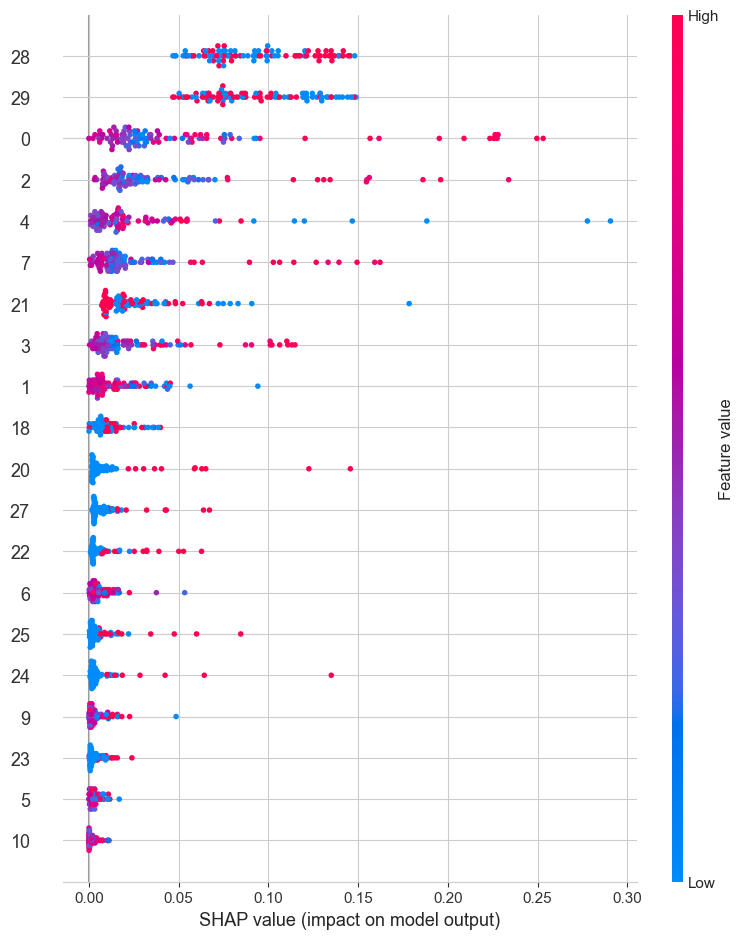

In [51]:
print(shap_values.values.shape)  # Should be (100, features) or (100, features, classes)

# For multi-class: average across class axis
if shap_values.values.ndim == 3:
    shap_vals_all = np.mean(np.abs(shap_values.values), axis=2)
else:
    shap_vals_all = shap_values.values

# ✅ Plot using same data passed to explainer
shap.summary_plot(shap_vals_all, X_eval_processed[0:100])

In [ ]:
#decision tree 

#tell a story , kofi goes to the bank instead of waiting for long, why is it important , it saves time , then reason for using machine learning 